In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
import shap
shap.initjs()

import graphviz
from sklearn.tree import export_graphviz
import pydot

In [4]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.cluster import FeatureAgglomeration

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from scipy.stats import rankdata

from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils import np_utils

Using TensorFlow backend.


this function is used to get the precision of the model @ top K

In [5]:
def score_topK(yv, ypred):
    print('Precision @')
    ttest = pd.DataFrame({'true':yv,'pred1':ypred})
    ttest['ranking'] = rankdata(ttest.pred1, 'min')
    ttest['ranking'] = ttest.ranking.max()-ttest.ranking+1
    for topK in [50,100,150,175]:
        ttest['pred'+str(topK)] = ttest.ranking <= topK
        print('TOP K %d ' % (topK))
        if ttest.shape[0]:
            cm = confusion_matrix(ttest.true, ttest['pred'+str(topK)])
            print('-- %.2f #Churners: %d #TT: %d #FT: %d' %
                   (precision_score(ttest.true, ttest['pred'+str(topK)]).round(2),
                    cm[1][1]+cm[0][1], cm[1][1], cm[0][1]))
            
    return ttest.loc[ttest.ranking<=175, 'pred1'].min()

data is loaded, forecast features are discarded as well as empty columns - all tables are joined into a wide matrix indexed by client id

In [7]:
path = 'data/'
dates_cols = ['date_activ','date_end','date_first_activ','date_modif_prod','date_renewal']
cat_cols = ['activity_new', 'channel_sales', 'has_gas', 'origin_up']
target_cols = ['churn']

training_data = pd.read_csv(path+'ml_case_training_data.csv', parse_dates=dates_cols).dropna(axis=1, how='all')
training_hist_data = pd.read_csv(path+'ml_case_training_hist_data.csv')
training_output = pd.read_csv(path+'ml_case_training_output.csv')
test_data = pd.read_csv(path+'ml_case_test_data.csv', parse_dates=dates_cols, usecols=training_data.columns)
test_hist_data = pd.read_csv(path+'ml_case_test_hist_data.csv')

In [9]:
prices = ['price_p1_fix','price_p1_var','price_p2_fix','price_p2_var','price_p3_fix','price_p3_var']
df_hist_data = training_hist_data.append(test_hist_data).pivot_table(index='id', columns='price_date', values=prices)
df_hist_data.columns = ['_'.join(col).strip().replace('-','') for col in df_hist_data.columns.values]
ts_cols = df_hist_data.columns.tolist()

In [10]:
all_cols = training_data.columns.tolist()
num_cols = list(set(all_cols)-set(dates_cols)-set(ts_cols)-set(target_cols)-set(cat_cols)-set(['id']))
num_cols = [c for c in num_cols if 'forecast' not in c]
features = num_cols + cat_cols + dates_cols + ts_cols
len(features)

91

# monthly prices evolution

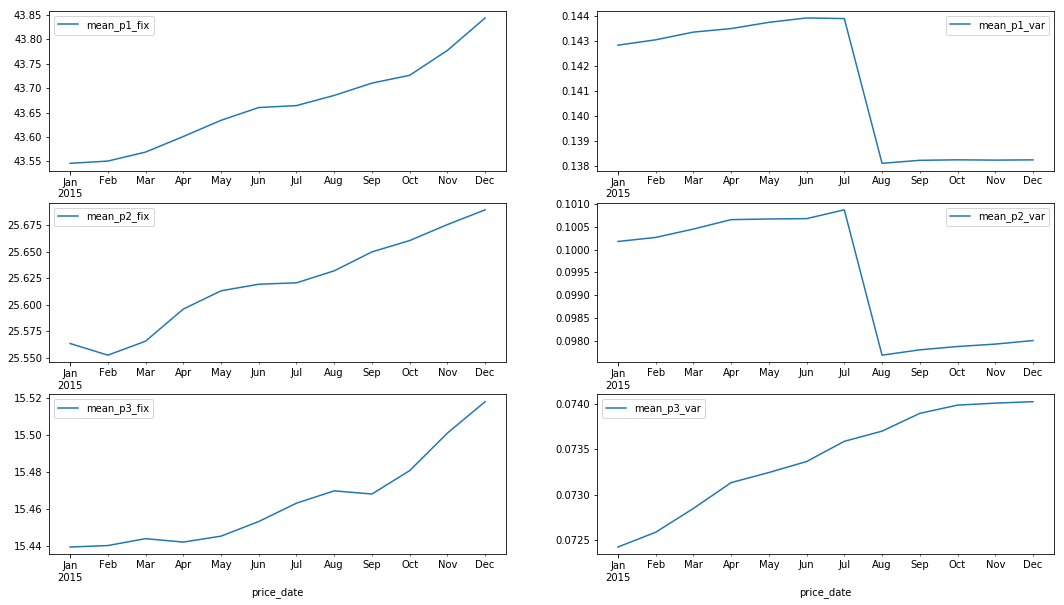

In [11]:
df = training_hist_data.append(test_hist_data).replace(0, np.nan)
df.price_date = pd.to_datetime(df.price_date)

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10);fig.set_figwidth(18)

for i,c in enumerate(prices):
    df.groupby('price_date')[c].mean().plot(ax=axes[i//2,i%2])
    axes[i//2,i%2].legend(['mean_'+c[6:]])

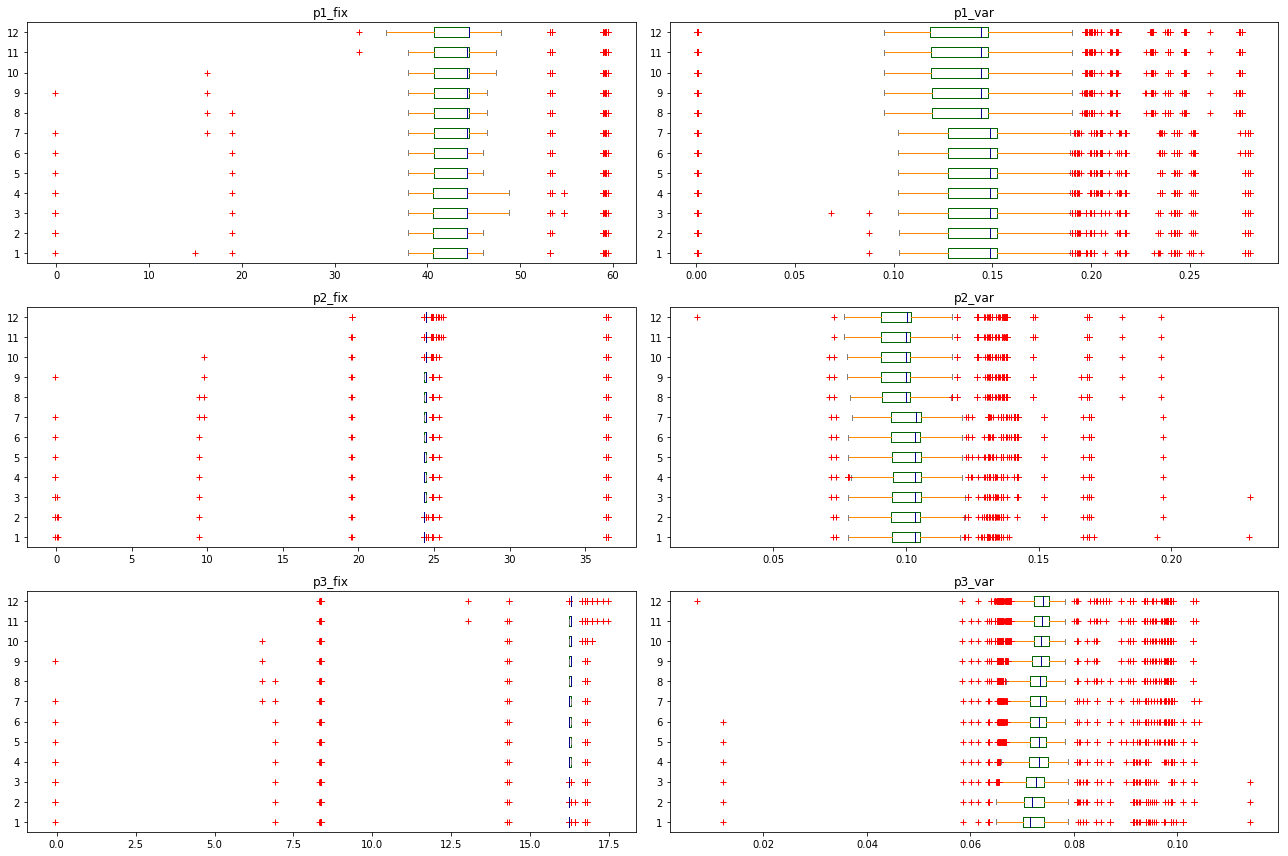

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(12);fig.set_figwidth(18)

for i,c in enumerate(prices):
    tmp = df[['id','price_date',c]]
    df.pivot(index='id', columns='price_date', 
             values=c).rename(lambda x: x.month, axis='columns').plot.box(ax=axes[i//2,i%2],
             color=dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray'), sym='r+',
             vert=False)
    axes[i//2,i%2].set_title(c[6:])
plt.tight_layout()

# cleaning and basic feature engineering

In [13]:
def get_df(scale=False, fillna=False):
    
    global training_data, training_output, test_data, df_hist_data, cat_cols, dates_cols, ts_cols, num_cols
    df = training_data.merge(training_output).append(test_data).set_index('id').join(df_hist_data)
    means = {}
    stds = {}
    
    for c in df.columns:
        if c in cat_cols:
            print('cat %s' % c)
            df[c] = df[c].astype('category').cat.codes
        elif c in dates_cols:
            print('date % s' % c)
            df[c] = pd.datetime(2016,1,1)-df[c]
            df.loc[df[c].notnull(), c] = df.loc[df[c].notnull(), c].dt.days.astype(int)
        if scale and c in dates_cols+ts_cols+num_cols:
            means[c]=df.loc[df.churn.notnull(), c].mean()
            stds[c]=df.loc[df.churn.notnull(), c].std()
            df[c]=((df[c]-means[c])/stds[c])
        if fillna and c in dates_cols+ts_cols+num_cols:
            df[c].fillna(df.loc[df.churn.notnull(), c].mean(), inplace=True)
            
    return df

df=get_df()

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


Viewing churning clients relative to some features

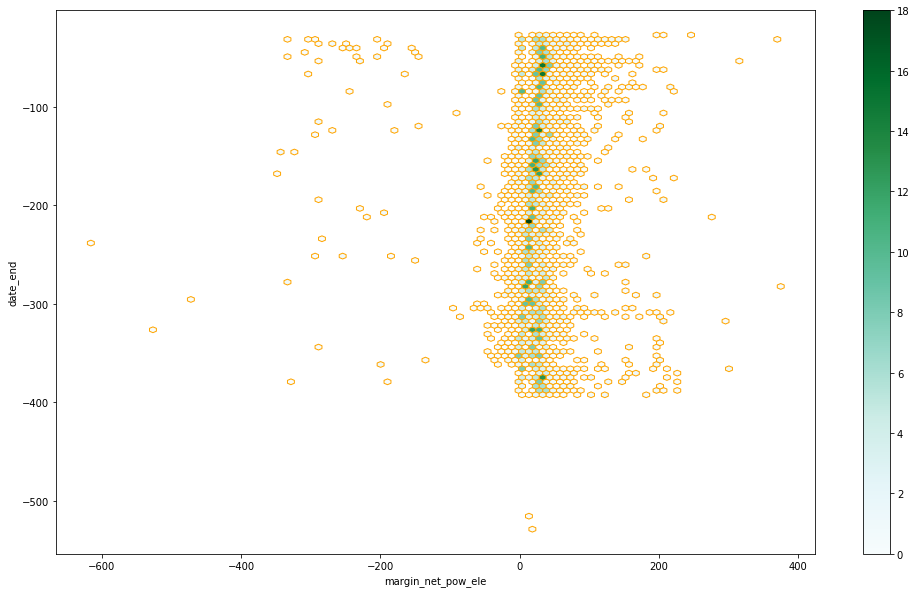

In [14]:
df.loc[(df.date_end<365)&(df.date_end>-365*2),
       ['margin_net_pow_ele','date_end','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_end', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

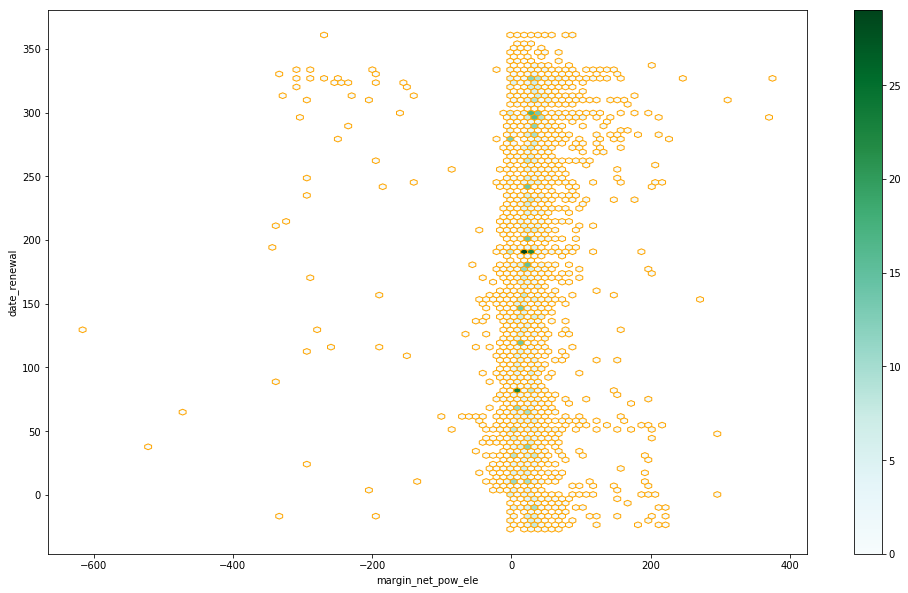

In [15]:
df.loc[(df.date_renewal<365)&(df.date_renewal>-365*2),
       ['margin_net_pow_ele','date_renewal','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_renewal', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

# decision Tree

In [16]:
df=get_df(scale=False, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


In [17]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xt, yt)
y_pred = dt.predict_proba(Xv)
score_topK(yv, y_pred[:,1])

Precision @
TOP K 50 
-- 0.29 #Churners: 31 #TT: 9 #FT: 22
TOP K 100 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63
TOP K 150 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63
TOP K 175 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63


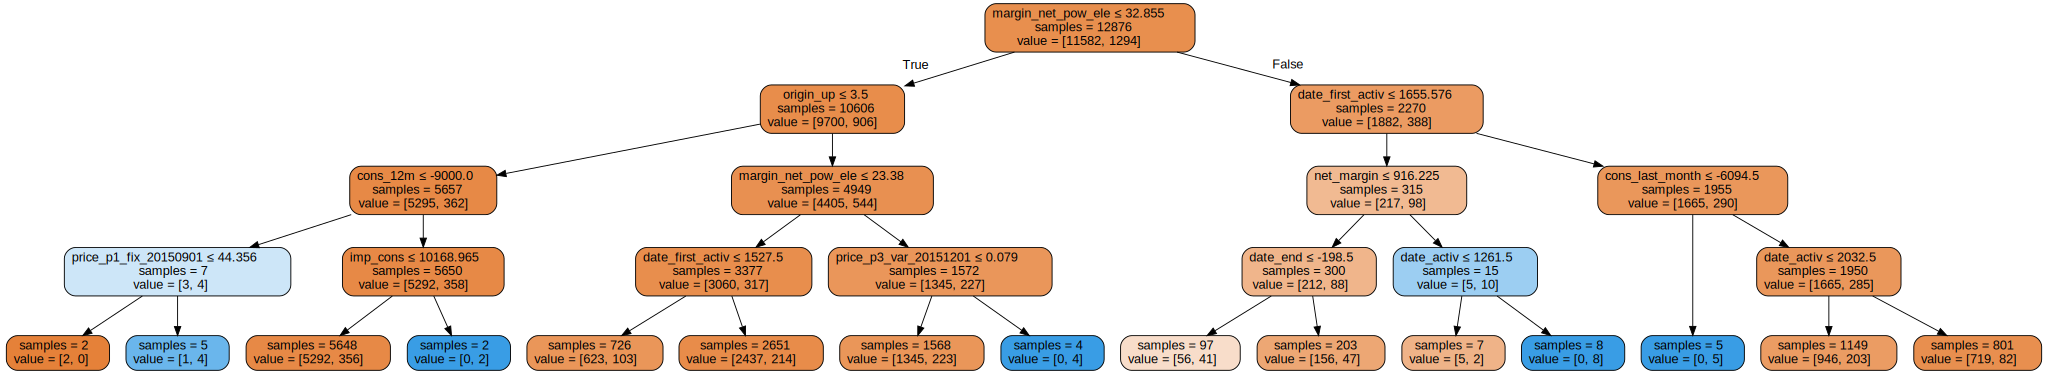

In [31]:
dot_data = export_graphviz(dt, out_file='dt', feature_names=features, filled=True, rounded=True, 
                           special_characters=True, impurity=False, rotate=False, leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph.from_file("dt")

In [32]:
(graph,) = pydot.graph_from_dot_file('dt')
graph.write_png('dt.png')

In [42]:
df=get_df(scale=True, fillna=True)

X = df.loc[df.churn.notnull(), [c for c in features if c not in cat_cols]]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

pipe = Pipeline(steps=[('fagg', FeatureAgglomeration()), ('logistic', linear_model.LogisticRegression())])
estimator = GridSearchCV(pipe,
                         dict(fagg__n_clusters=[2, 10, 20, 30],
                              logistic__C=np.logspace(-4, 4, 5)))
estimator.fit(Xt, yt)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('fagg', FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=2,
           pooling_func=<function mean at 0x7f79f4a2ff50>)), ('logistic', LogisticRegression(C=1.0, class...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logistic__C': array([  1.00000e-04,   1.00000e-02,   1.00000e+00,   1.00000e+02,
         1.00000e+04]), 'fagg__n_clusters': [2, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
score_topK(yv, estimator.predict_proba(Xv)[:,1])

Precision @
TOP K 50 
-- 0.18 #Churners: 50 #TT: 9 #FT: 41
TOP K 100 
-- 0.21 #Churners: 100 #TT: 21 #FT: 79
TOP K 150 
-- 0.19 #Churners: 150 #TT: 28 #FT: 122
TOP K 175 
-- 0.19 #Churners: 175 #TT: 33 #FT: 142


In [45]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('fagg', FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=10,
           pooling_func=<function mean at 0x7f79f4a2ff50>)), ('logistic', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

# KERAS for fun

In [55]:
df=get_df(scale=True, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


In [61]:
bcg_input_cat = [Input(shape=(1,)) for c in cat_cols]
bcg_input_num = Input(shape=(len(num_cols+dates_cols),))
bcg_input_ts = Input(shape=(12,6))

bcg_output_cat = [Flatten()(Dropout(0.1)(Embedding(df[c].max()+2, 2)(x))) for c,x in zip(cat_cols, bcg_input_cat)]
bcg_output_num = Dropout(0.1)(Dense(100, activation='selu')(bcg_input_num))
bcg_output_ts = Bidirectional(LSTM(25, return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1),
                              merge_mode='ave')(bcg_input_ts)
bcg_output_ts = LSTM(26, return_sequences=False, dropout= 0.1, recurrent_dropout= 0.1)(bcg_output_ts)

bcg_output = concatenate(bcg_output_cat + [bcg_output_num, bcg_output_ts])
bcg_output = Dense(100, activation='selu')(bcg_output)
bcg_output = Dropout(0.5)(bcg_output)
bcg_output = Dense(100, activation='selu')(bcg_output)
bcg_output = Dropout(0.1)(bcg_output)
bcg_output = Dense(2, activation='softmax')(bcg_output)

In [62]:
bcg_model = Model(bcg_input_cat+[bcg_input_num, bcg_input_ts], bcg_output)

In [63]:
bcg_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
bcg_model.fit(
    [Xt[c].as_matrix()+1 for c in cat_cols]+[Xt[num_cols+dates_cols].values,
                                           Xt[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)],
     np_utils.to_categorical(yt, 2),
     epochs=20,
     batch_size=100,
     shuffle=True,
     validation_data=([Xv[c].as_matrix()+1 for c in cat_cols]+[Xv[num_cols+dates_cols].values,
                                                             Xv[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)], 
                      np_utils.to_categorical(yv, 2))
)

Train on 12876 samples, validate on 3220 samples
Epoch 1/20
12876/12876 [==============================] - 6s 451us/step - loss: 0.3729 - acc: 0.8819 - val_loss: 0.3048 - val_acc: 0.9037
Epoch 2/20
12876/12876 [==============================] - 3s 268us/step - loss: 0.3353 - acc: 0.8977 - val_loss: 0.2992 - val_acc: 0.9056
Epoch 3/20
12876/12876 [==============================] - 4s 273us/step - loss: 0.3303 - acc: 0.8981 - val_loss: 0.3070 - val_acc: 0.9062
Epoch 4/20
12876/12876 [==============================] - 4s 277us/step - loss: 0.3266 - acc: 0.8981 - val_loss: 0.3026 - val_acc: 0.9047
Epoch 5/20
12876/12876 [==============================] - 4s 273us/step - loss: 0.3238 - acc: 0.8978 - val_loss: 0.3003 - val_acc: 0.9065
Epoch 6/20
12876/12876 [==============================] - 4s 273us/step - loss: 0.3207 - acc: 0.8989 - val_loss: 0.3049 - val_acc: 0.9016
Epoch 7/20
12876/12876 [==============================] - 3s 270us/step - loss: 0.3177 - acc: 0.8989 - val_loss: 0.2966 - v

In [65]:
score_topK(yv,
           bcg_model.predict([Xv[c].as_matrix()+1 for c in cat_cols]+[Xv[num_cols+dates_cols].values,
                                    Xv[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)])[:,1])

Precision @
TOP K 50 
-- 0.36 #Churners: 50 #TT: 18 #FT: 32
TOP K 100 
-- 0.28 #Churners: 100 #TT: 28 #FT: 72
TOP K 150 
-- 0.29 #Churners: 150 #TT: 44 #FT: 106
TOP K 175 
-- 0.28 #Churners: 175 #TT: 49 #FT: 126


# XGB

In [66]:
df=get_df(scale=False, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt.as_matrix(), label=yt.as_matrix())
dv = xgb.DMatrix(Xv.as_matrix(), label=yv.as_matrix())

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


### starter

In [76]:
params = {
    "eta": 0.2,
    "max_depth": 4,
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model0 = xgb.train(params, dt, 100, [(dt, "train"),(dv, "valid")], verbose_eval=100)
score_topK(yv, model0.predict(dv))

[0]	train-logloss:0.319065	valid-logloss:0.304828
[99]	train-logloss:0.224409	valid-logloss:0.269813
Precision @
TOP K 50 
-- 0.70 #Churners: 50 #TT: 35 #FT: 15
TOP K 100 
-- 0.58 #Churners: 100 #TT: 58 #FT: 42
TOP K 150 
-- 0.49 #Churners: 150 #TT: 73 #FT: 77
TOP K 175 
-- 0.44 #Churners: 175 #TT: 77 #FT: 98


In [77]:
shap_values = model0.predict(dv, pred_contribs=True)

In [78]:
shap.visualize(shap_values[0,:], feature_names=Xv.columns, data=Xv.iloc[0,:])

<iml.explanations.AdditiveExplanation instance at 0x7f79606bb1b8>

In [79]:
shap.visualize(shap_values[:100,:], feature_names=Xv.columns, data=Xv.values[:100,:])

[<iml.explanations.AdditiveExplanation instance at 0x7f79606bbd88>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79606bbf38>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059f128>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059f2d8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059f488>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059f638>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059f7e8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059f998>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059fb48>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059fcf8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f796059fea8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4098>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4248>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b43f8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b45a8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4758>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4908>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4ab8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4c68>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4e18>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605b4fc8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605361b8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536368>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536518>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605366c8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536878>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536a28>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536bd8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536d88>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960536f38>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506128>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605062d8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506488>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506638>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605067e8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506998>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506b48>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506cf8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7960506ea8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79604ce098>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79604ce248>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79604ce3f8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79604ce5a8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79606bb950>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79606bb518>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79606bb5a8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79606bb290>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605957a0>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d23f8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d2248>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d2098>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d5ea8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d5cf8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d5b48>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d5998>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d57e8>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d5638>,
 <iml.explanations.AdditiveExplanation instance at 0x7f79605d5488>,
 <iml.explanations.AdditiveExplanation instance at 0x7f7

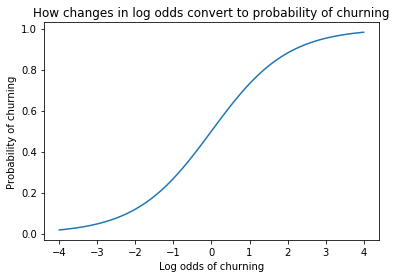

In [80]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of churning")
plt.ylabel("Probability of churning")
plt.title("How changes in log odds convert to probability of churning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

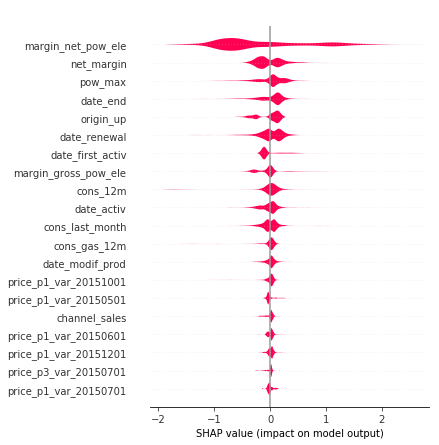

In [82]:
shap.summary_plot(shap_values, Xv.columns, max_display=20)

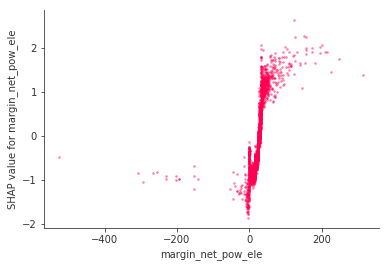

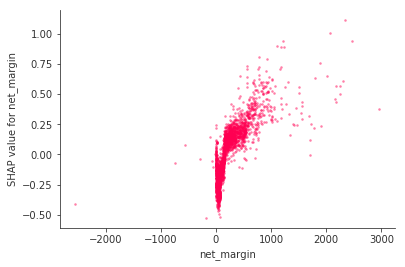

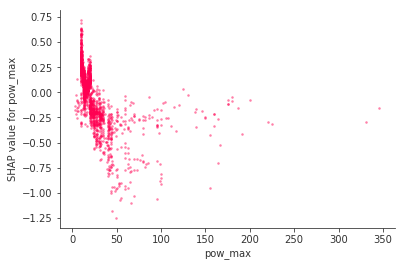

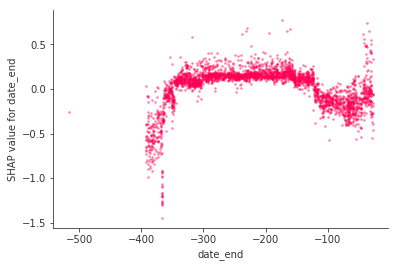

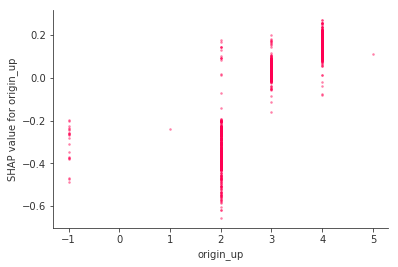

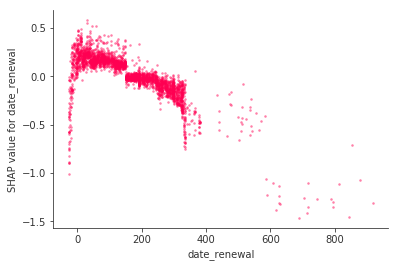

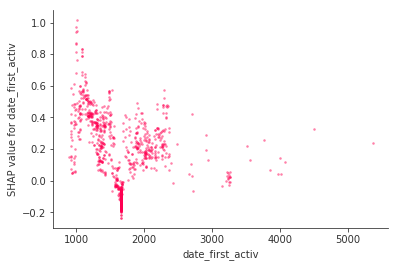

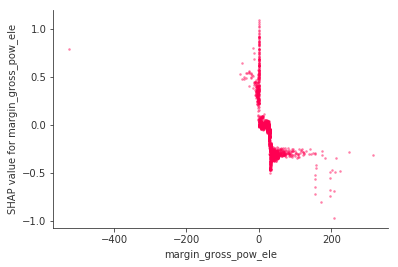

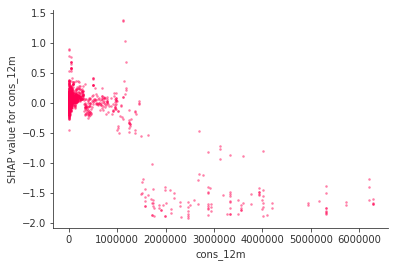

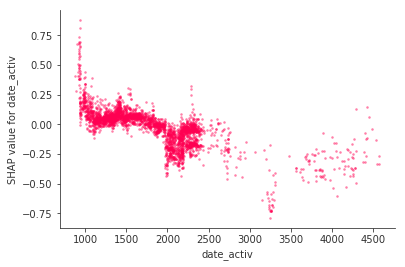

In [83]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[:,:len(features)]), 0))
for i in range(10):
    shap.plot(Xv.iloc[:,top_inds[i]], shap_values[:,top_inds[i]], Xv.columns[top_inds[i]], alpha=0.5)

In [84]:
top_inds

array([ 1,  7,  6, 15, 13, 18, 16,  9,  5, 14,  8,  0, 17, 40, 35, 11, 36,
       42, 85, 37,  3, 38, 55, 10, 65, 77, 31, 81, 62, 78, 41, 30, 21, 43,
       67, 33, 84, 87, 34, 39, 66, 79, 59, 12, 32, 56, 54, 88, 57, 80, 47,
        2, 82, 64, 90, 76, 63, 25, 71, 89, 61, 27, 60, 73, 22, 58,  4, 20,
       28, 83, 23, 24, 19, 26, 86, 52, 72, 74, 53, 70, 69, 68, 29, 44, 46,
       48, 49, 50, 51, 75, 45])

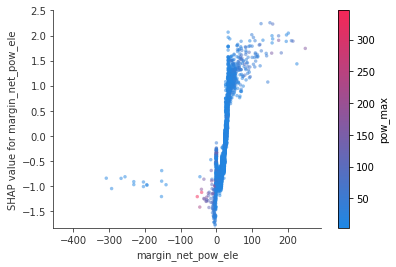

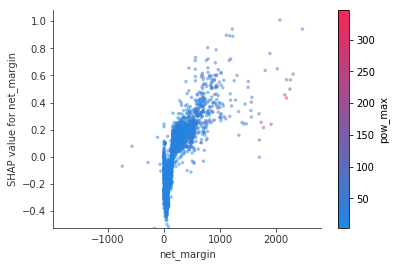

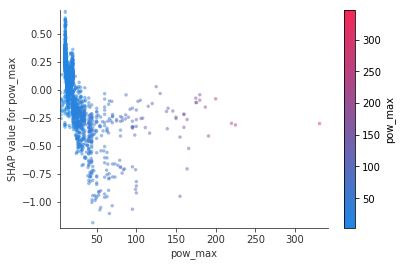

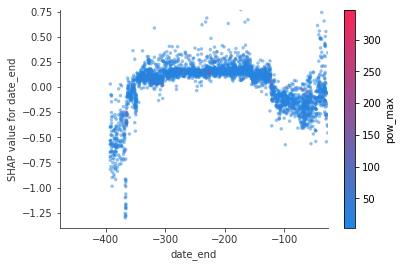

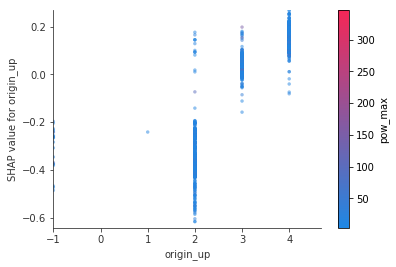

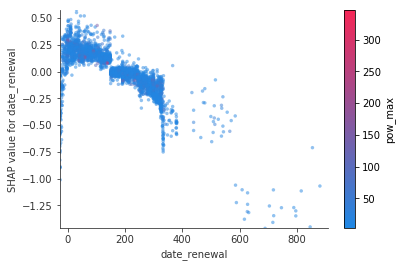

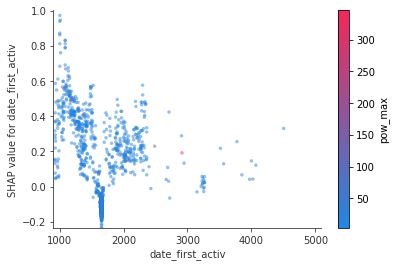

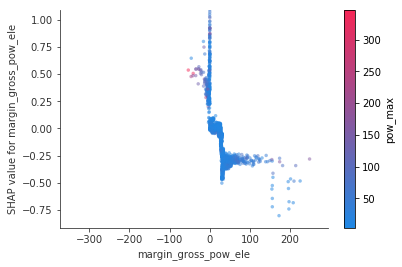

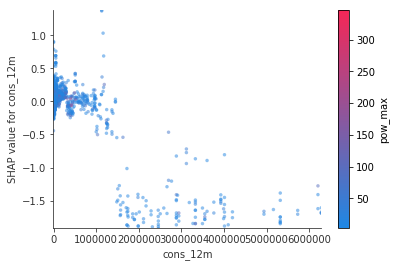

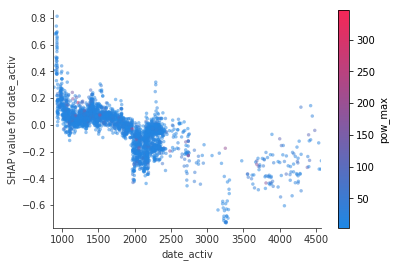

In [88]:
for i in range(10):
    plt.xlim(np.percentile(Xv.iloc[:,top_inds[i]], 0.01), np.percentile(Xv.iloc[:,top_inds[i]], 99.99))
    plt.ylim(np.percentile(shap_values[:,top_inds[i]], 0.01), np.percentile(shap_values[:,top_inds[i]], 99.99))
    shap.interaction_plot(top_inds[i], Xv, shap_values, alpha=.5, interaction_index=6)

### Train a model on just one feature to see marginal association

In [99]:
ind = np.where(Xv.columns == features[top_inds[0]])[0][0]
Xt_min = Xt.iloc[:,ind:ind+1]
Xv_min = Xv.iloc[:,ind:ind+1]
dt_min = xgb.DMatrix(Xt_min,label=yt.as_matrix())
dv_min = xgb.DMatrix(Xv_min,label=yv.as_matrix())
params = {
    "eta": 0.1,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model_min = xgb.train(params, dt_min, 100, [(dt_min, "train"),(dv_min, "valid")], verbose_eval=10)

[0]	train-logloss:0.324127	valid-logloss:0.309293
[10]	train-logloss:0.315311	valid-logloss:0.302996
[20]	train-logloss:0.312775	valid-logloss:0.302362
[30]	train-logloss:0.311043	valid-logloss:0.302314
[40]	train-logloss:0.309892	valid-logloss:0.302451
[50]	train-logloss:0.30865	valid-logloss:0.302769
[60]	train-logloss:0.30746	valid-logloss:0.302913
[70]	train-logloss:0.306524	valid-logloss:0.303122
[80]	train-logloss:0.305667	valid-logloss:0.303319
[90]	train-logloss:0.304672	valid-logloss:0.303326
[99]	train-logloss:0.304025	valid-logloss:0.303586


In [100]:
shap_values_min = model_min.predict(dv_min, pred_contribs=True)

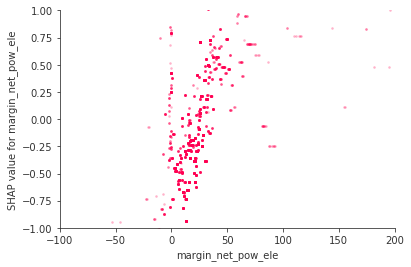

In [101]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv_min.iloc[:,0], shap_values_min[:,0], Xv_min.columns[0], alpha=0.3)

### Train a model with only two leaves per tree and hence no interaction terms between features

In [102]:
params = {
    "max_bin": 512,
    "eta": 0.1,
    "num_leaves": 2,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    "min_data": 100,
    "boost_from_average": True,
    "verbose": -1,
}

model_ind = xgb.train(params, dt, 200, [(dt, "train"),(dv, "valid")], verbose_eval=100)

[0]	train-logloss:0.318618	valid-logloss:0.305987
[100]	train-logloss:0.203992	valid-logloss:0.266994
[199]	train-logloss:0.157593	valid-logloss:0.267249


In [103]:
shap_values_ind = model_ind.predict(dv, pred_contribs=True)

In [104]:
np.argsort(-np.sum(np.abs(shap_values_ind[:,:len(features)]), 0))

array([ 1,  9,  6, 18, 13,  5, 15,  7, 16,  8, 14,  0, 17, 35, 41,  3, 11,
       36, 40, 55, 34, 42, 37, 10, 31, 38, 63, 77, 65, 33, 32, 79, 81, 60,
       61, 66, 39, 21, 85, 84, 89, 30, 62, 59, 82, 86, 58, 67,  2, 87, 56,
       88, 90, 64, 57, 29, 28, 12, 47, 83, 23, 26, 24, 80, 52, 25, 43,  4,
       78, 50, 73, 19, 48, 76, 75, 53, 72, 44, 71, 54, 20, 74, 69, 46, 51,
       70, 68, 49, 45, 27, 22])

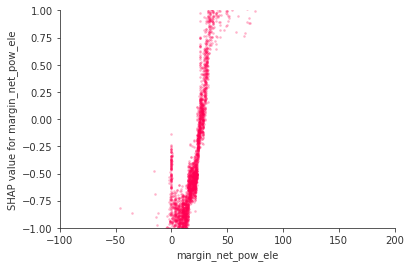

In [108]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,1], shap_values[:,1], Xv.columns[1], alpha=0.3)

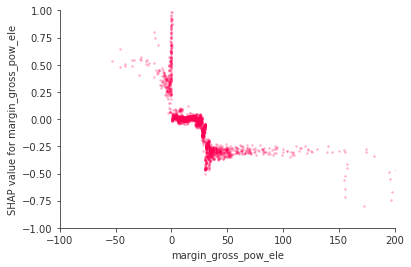

In [109]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,9], shap_values[:,9], Xv.columns[9], alpha=0.3)

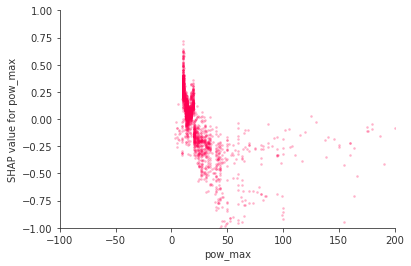

In [110]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,6], shap_values[:,6], Xv.columns[6], alpha=0.3)

# Submission model

In [68]:
params = {
    "eta": 0.01,
    "max_depth": 6,
    "objective": "binary:logistic",
    "silent": 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 1800, [(dt, "train"),(dv, "valid")], verbose_eval=100)

[0]	train-logloss:0.325504	valid-logloss:0.310454
[100]	train-logloss:0.283027	valid-logloss:0.286343
[200]	train-logloss:0.264646	valid-logloss:0.278608
[300]	train-logloss:0.253609	valid-logloss:0.274902
[400]	train-logloss:0.24379	valid-logloss:0.272318
[500]	train-logloss:0.234253	valid-logloss:0.270181
[600]	train-logloss:0.22446	valid-logloss:0.26811
[700]	train-logloss:0.216138	valid-logloss:0.266856
[800]	train-logloss:0.2077	valid-logloss:0.265434
[900]	train-logloss:0.200304	valid-logloss:0.264979
[1000]	train-logloss:0.193617	valid-logloss:0.264585
[1100]	train-logloss:0.187153	valid-logloss:0.264109
[1200]	train-logloss:0.180439	valid-logloss:0.263507
[1300]	train-logloss:0.174329	valid-logloss:0.262939
[1400]	train-logloss:0.168863	valid-logloss:0.262709
[1500]	train-logloss:0.163305	valid-logloss:0.26233
[1600]	train-logloss:0.157887	valid-logloss:0.262356
[1700]	train-logloss:0.152327	valid-logloss:0.262298
[1799]	train-logloss:0.147657	valid-logloss:0.262012


In [140]:
model.predict(xgb.DMatrix(X.as_matrix()))

array([ 0.02599962,  0.66920948,  0.04954993, ...,  0.29344943,
        0.05115744,  0.06131972], dtype=float32)

### Submission is made in a way to reach 50% precision

In [120]:
score_topK(yv, model.predict(dv))

Precision @
TOP K 50 
-- 0.82 #Churners: 50 #TT: 41 #FT: 9
TOP K 100 
-- 0.69 #Churners: 100 #TT: 69 #FT: 31
TOP K 150 
-- 0.56 #Churners: 150 #TT: 84 #FT: 66
TOP K 175 
-- 0.50 #Churners: 175 #TT: 87 #FT: 88


0.2481351

In [113]:
Xs = df.loc[df.churn.isnull(), features]
ds = xgb.DMatrix(Xs.as_matrix())

In [123]:
Xs['Churn_probability'] = model.predict(ds)
Xs.loc[Xs.Churn_probability>0.2481351, 'Churn_prediction'] = 1

In [131]:
pd.read_csv(path+'ml_case_test_output_template.csv', 
            usecols=['id'], index_col=0).join(Xs[['Churn_prediction','Churn_probability']]).fillna(0).to_csv(
'ml_case_test_output.csv')

In [132]:
! head ml_case_test_output.csv

id,Churn_prediction,Churn_probability
ed18c9981ce183ef347246cdcc55f743,0.0,0.0562928058207
9c341e73685fcff6e3527ebd51da3fe5,0.0,0.0441493242979
97dd64b33716aadc4e22c4ab85d1c7a4,0.0,0.150151371956
cf81de72ff7997ed10729751059cf7a3,0.0,0.113111659884
c7c8ee9daf2a864d159d45a2373ada72,0.0,0.0728675723076
e71dcb748e269fee09b9f42f4c52fcc4,0.0,0.0581501722336
09bf08782759c0f550bdfcdcbcc5204f,0.0,0.10489436239
b4f626597ef9df75224af10e47842e54,0.0,0.0757908672094
0218b6cd2582012e85e3fa88512edd74,0.0,0.0416416637599


### Churn_probability threshold were we can make 20% discount

In [173]:
res = Xv.copy()
res['Churn_probability'] = model.predict(dv)
res['Churn_true'] = yv
res = res[['Churn_probability','Churn_true']].sort_values('Churn_probability', ascending=False)
res['ranking0'] = range(1,res.shape[0]+1)
res = res.join(df.forecast_bill_12m).dropna()
res['real_bill'] = res.forecast_bill_12m*(1-res.Churn_true)
res['new_bill'] = res.forecast_bill_12m*.8
res['gain'] = res.new_bill - res.real_bill
res['cum_gain'] = res['gain'].cumsum()
res['ranking'] = range(1,res.shape[0]+1)
print res.shape, Xv.shape
res.loc[res.ranking<=404].tail(20)

(710, 9) (3220, 93)


,Churn_probability,Churn_true,ranking0,forecast_bill_12m,real_bill,new_bill,gain,cum_gain,ranking
id,,,,,,,,,
80cb523b9b5b6480f8d1e88d92bbfd83,0.085304,0.0,1026,1269.15,1269.15,1015.320,-253.830,5999.102,385
f81a41be910d40f9117a1733e04ff7d5,0.085228,0.0,1028,900.09,900.09,720.072,-180.018,5819.084,386
b4b81ece51e0fa4ec2b6a17255270e80,0.085150,0.0,1030,24983.50,24983.50,19986.800,-4996.700,822.384,387
6f825701c85d413840e4cec42835c783,0.084910,0.0,1035,1942.14,1942.14,1553.712,-388.428,433.956,388
31b20b15755dc71378831eede0f3f1fd,0.084776,1.0,1038,686.66,0.00,549.328,549.328,983.284,389
a855d3fc9654f6833b939fa4f3e74c06,0.084058,0.0,1047,3284.92,3284.92,2627.936,-656.984,326.300,390
9fe197bb99e85553722b115e0a5d0483,0.083906,1.0,1051,2212.84,0.00,1770.272,1770.272,2096.572,391
b2b1e0837db7f608b5bbb1bacc0cf49d,0.083818,0.0,1054,2635.28,2635.28,2108.224,-527.056,1569.516,392
8aa9711362a9140e7596bcdb886a7a2e,0.083426,0.0,1060,2878.98,2878.98,2303.184,-575.796,993.720,393


# Extra

In [99]:
params = {'nthread':[1],
          'objective':['binary:logistic'],
          'learning_rate': [0.01],
          'max_depth': [5,6],
          'silent': [0],
          'subsample': [0.6,0.8],
          'colsample_bytree': [0.6,0.8],
          'n_estimators': [1500],
          #'missing':[-999],
          'seed': [1227]
}
from sklearn.cross_validation import StratifiedKFold
clf = GridSearchCV(xgb.XGBClassifier(), params, n_jobs=4, 
                   cv=StratifiedKFold(yt, n_folds=2, shuffle=True), 
                   scoring='roc_auc',
                   verbose=0, refit=True)
clf.fit(Xt, yt)

/Users/senoni/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 0.  0. ...,  0.  0.], n_folds=2, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [1500], 'subsample': [0.6, 0.8], 'seed': [1227], 'colsample_bytree': [0.6, 0.8], 'silent': [0], 'objective': ['binary:logistic'], 'learning_rate': [0.01], 'nthread': [1], 'max_depth': [5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [100]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1227, silent=0,
       subsample=0.8)